In [89]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.16.1


In [90]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/9p/qgmj63p14w703cqkv91mlccm0000gn/T/pip-req-build-e8v3a93s
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/9p/qgmj63p14w703cqkv91mlccm0000gn/T/pip-req-build-e8v3a93s
  Resolved https://github.com/tensorflow/docs to commit ec3a1b3f9a604c6cd26c7537f2b9fd270a3eedbf
  Preparing metadata (setup.py) ... done


In [91]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.16.1


In [92]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [93]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [94]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [95]:
FEATURES = 28

In [96]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [97]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [98]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


2024-04-04 01:37:20.669481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


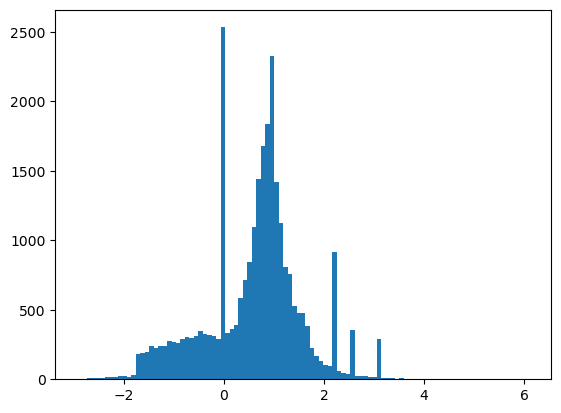

In [99]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [100]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [101]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [102]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [103]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [104]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

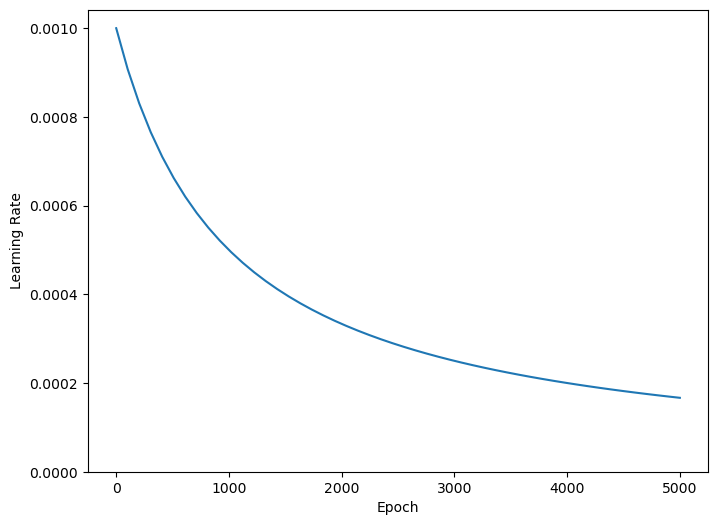

In [105]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [106]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [131]:
import tensorflow as tf

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                      'accuracy'])

    model.summary()

    # `.repeat()` 메서드를 사용하여 데이터셋이 에포크 간에 반복되도록 설정합니다.
    train_ds_repeat = train_ds.repeat()
    validate_ds_repeat = validate_ds.repeat()

    # steps_per_epoch과 validation_steps를 설정합니다.
    # 여기서 STEPS_PER_EPOCH와 VALIDATION_STEPS는 각각 훈련 및 검증 데이터셋의 크기를 배치 크기로 나눈 값입니다.
    # 이 값들은 데이터셋과 배치 크기에 따라 다르므로, 실제 상황에 맞게 조정해야 합니다.
    # 예시: STEPS_PER_EPOCH = 200, VALIDATION_STEPS = 50
    # 이 값들을 동적으로 계산하려면, 데이터셋의 전체 샘플 수를 배치 크기로 나누어야 합니다.
    
    history = model.fit(
        train_ds_repeat,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds_repeat,
        validation_steps=50,  # 이 부분을 추가하거나, validate_ds에서 `.repeat()`를 사용했다면 생략 가능
        callbacks=get_callbacks(name),
        verbose=0)
    return history


In [132]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [133]:
size_histories = {}

In [134]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4770,  binary_crossentropy:0.8697,  loss:0.8697,  val_accuracy:0.4780,  val_binary_crossentropy:0.8085,  val_loss:0.8085,  
....................................................................................................
Epoch: 100, accuracy:0.5962,  binary_crossentropy:0.6269,  loss:0.6269,  val_accuracy:0.5670,  val_binary_crossentropy:0.6359,  val_loss:0.6359,  
....................................................................................................
Epoch: 200, accuracy:0.6094,  binary_crossentropy:0.6153,  loss:0.6153,  val_accuracy:0.6050,  val_binary_crossentropy:0.6216,  val_loss:0.6216,  
....................................................................................................
Epoch: 300, accuracy:0.6282,  binary_crossentropy:0.6065,  loss:0.6065,  val_accuracy:0.6190,  val_binary_crossentropy:0.6140,  val_loss:0.6140,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

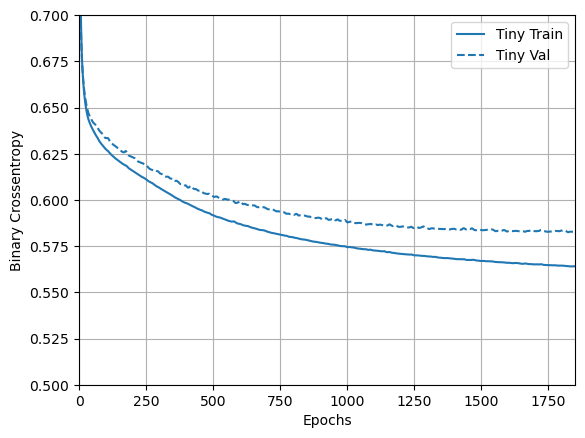

In [135]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [136]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [137]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5089,  binary_crossentropy:0.7157,  loss:0.7157,  val_accuracy:0.4790,  val_binary_crossentropy:0.7045,  val_loss:0.7045,  
....................................................................................................
Epoch: 100, accuracy:0.6333,  binary_crossentropy:0.6047,  loss:0.6047,  val_accuracy:0.6350,  val_binary_crossentropy:0.6092,  val_loss:0.6092,  
....................................................................................................
Epoch: 200, accuracy:0.6666,  binary_crossentropy:0.5864,  loss:0.5864,  val_accuracy:0.6280,  val_binary_crossentropy:0.5929,  val_loss:0.5929,  
....................................................................................................
Epoch: 300, accuracy:0.6736,  binary_crossentropy:0.5774,  loss:0.5774,  val_accuracy:0.6840,  val_binary_crossentropy:0.5840,  val_loss:0.5840,  
....................................................................................................
Epoch: 40

In [138]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [139]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [140]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5136,  binary_crossentropy:0.7558,  loss:0.7558,  val_accuracy:0.5470,  val_binary_crossentropy:0.6798,  val_loss:0.6798,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0021,  loss:0.0021,  val_accuracy:0.6700,  val_binary_crossentropy:1.7674,  val_loss:1.7674,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6730,  val_binary_crossentropy:2.4038,  val_loss:2.4038,  
...........................

Text(0.5, 0, 'Epochs [Log Scale]')

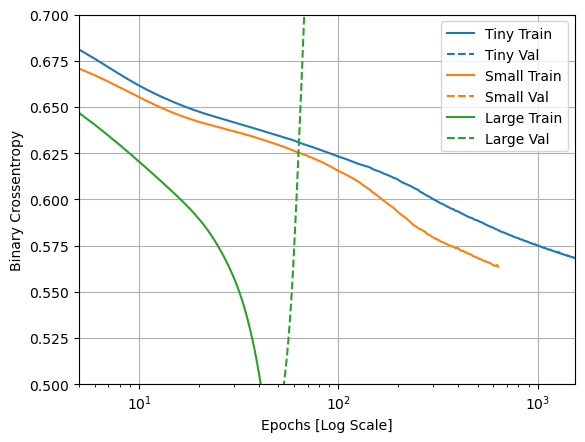

In [117]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [141]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4591), started 0:22:29 ago. (Use '!kill 4591' to kill it.)

In [142]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [143]:
tensorboard dev upload --logdir  {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.

In [144]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/9p/qgmj63p14w703cqkv91mlccm0000gn/T/tmp_952wfag/tensorboard_logs/regularizers/Tiny')

In [145]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [146]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5067,  binary_crossentropy:0.7687,  loss:2.2687,  val_accuracy:0.5350,  val_binary_crossentropy:0.6744,  val_loss:2.0837,  
....................................................................................................
Epoch: 100, accuracy:0.6577,  binary_crossentropy:0.5934,  loss:0.6167,  val_accuracy:0.6520,  val_binary_crossentropy:0.5871,  val_loss:0.6104,  
....................................................................................................
Epoch: 200, accuracy:0.6680,  binary_crossentropy:0.5834,  loss:0.6064,  val_accuracy:0.6670,  val_binary_crossentropy:0.5830,  val_loss:0.6059,  
....................................................................................................
Epoch: 300, accuracy:0.6735,  binary_crossentropy:0.5783,  loss:0.6003,  val_accuracy:0.6690,  val_binary_crossentropy:0.5840,  val_loss:0.6060,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

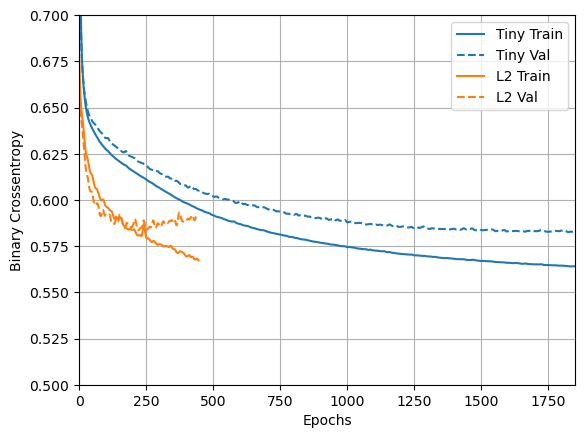

In [147]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [148]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [151]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.7926,  loss:0.7926,  val_accuracy:0.5180,  val_binary_crossentropy:0.6729,  val_loss:0.6729,  
....................................................................................................
Epoch: 100, accuracy:0.6616,  binary_crossentropy:0.5940,  loss:0.5940,  val_accuracy:0.6770,  val_binary_crossentropy:0.5720,  val_loss:0.5720,  
....................................................................................................
Epoch: 200, accuracy:0.6914,  binary_crossentropy:0.5566,  loss:0.5566,  val_accuracy:0.6840,  val_binary_crossentropy:0.5845,  val_loss:0.5845,  
....................................................................................................
Epoch: 300, accuracy:0.7157,  binary_crossentropy:0.5133,  loss:0.5133,  val_accuracy:0.6790,  val_binary_crossentropy:0.6032,  val_loss:0.6032,  
.

(0.5, 0.7)

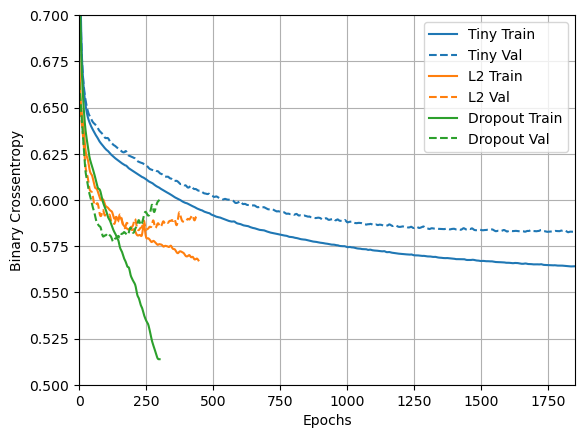

In [152]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [153]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4992,  binary_crossentropy:0.8031,  loss:0.9615,  val_accuracy:0.5630,  val_binary_crossentropy:0.6779,  val_loss:0.8356,  
....................................................................................................
Epoch: 100, accuracy:0.6428,  binary_crossentropy:0.6047,  loss:0.6342,  val_accuracy:0.6360,  val_binary_crossentropy:0.5845,  val_loss:0.6139,  
....................................................................................................
Epoch: 200, accuracy:0.6621,  binary_crossentropy:0.5922,  loss:0.6169,  val_accuracy:0.6920,  val_binary_crossentropy:0.5737,  val_loss:0.5984,  
....................................................................................................
Epoch: 300, accuracy:0.6727,  binary_crossentropy:0.5828,  loss:0.6110,  val_accuracy:0.6610,  val_binary_crossentropy:0.5720,  val_loss:0.6002,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

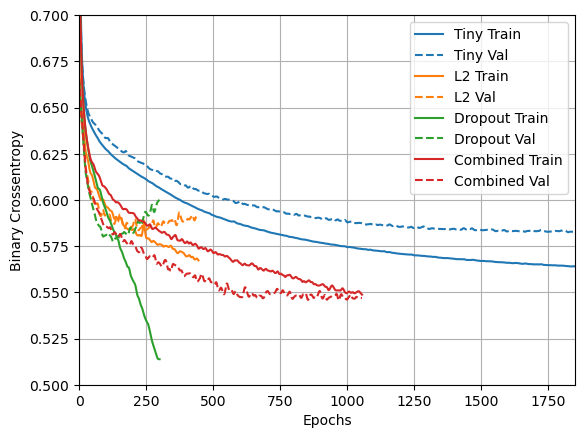

In [154]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

(0.5, 0.7)

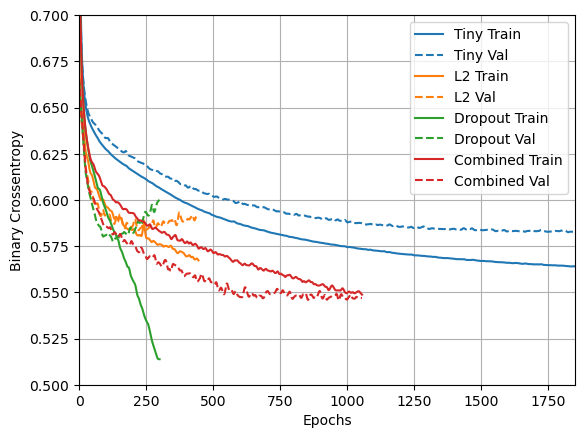

In [155]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [156]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

In [157]:
tensorboard dev upload --logdir  {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.